In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CheckpointConfig
from ray.tune.search.basic_variant import BasicVariantGenerator
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import json
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')


In [2]:
from dataloader.ts_reader import MultiModalDataset, collate_fn_pre_train
from model.autoencoder_ts import TimeSeriesAutoencoder

In [3]:
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"

lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)

lstm_loader_train = DataLoader(lstm_dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn_pre_train)
lstm_loader_val = DataLoader(lstm_dataset_val, batch_size=32, shuffle=False,collate_fn=collate_fn_pre_train)

In [4]:
import gc
gc.collect()

import torch

torch.cuda.empty_cache()

In [3]:
import ray
ray.init()
print(ray.available_resources()) 

2025-03-06 22:43:25,021	INFO worker.py:1841 -- Started a local Ray instance.


{'node:__internal_head__': 1.0, 'CPU': 64.0, 'memory': 852766956544.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 200000000000.0, 'GPU': 8.0, 'node:192.168.60.144': 1.0}


In [4]:
import ray
ray.shutdown()
ray.init(runtime_env={"working_dir": "/home/mei/nas/docker/thesis/model_train"})
ray.init(ignore_reinit_error=True, _temp_dir="/home/mei/nas/docker/thesis/data/ray_results")


2025-03-06 22:43:30,857	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-06 22:43:30,903	INFO packaging.py:575 -- Creating a file package for local module '/home/mei/nas/docker/thesis/model_train'.
2025-03-06 22:43:30,957	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_6560cf3e78af6e56.zip' (1.72MiB) to Ray cluster...
2025-03-06 22:43:30,964	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_6560cf3e78af6e56.zip'.
2025-03-06 22:43:31,754	INFO worker.py:1672 -- Calling ray.init() again after it has already been called.


Python version:,3.10.14
Ray version:,2.43.0


(train_autoencoder pid=868828) Epoch 1/10, Validation Loss: 0.0409
(train_autoencoder pid=868825) Epoch 1/10, Validation Loss: 0.1579
(train_autoencoder pid=868827) Epoch 1/10, Validation Loss: 0.0793
(train_autoencoder pid=868827) Epoch 2/10, Validation Loss: 0.0451 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_autoencoder pid=868825) Epoch 2/10, Validation Loss: 0.1533
(train_autoencoder pid=868828) Epoch 2/10, Validation Loss: 0.0307
(train_autoencoder pid=868825) Epoch 3/10, Validation Loss: 0.1481 [repeated 2x across cluster]
(train_autoencoder pid=868827) Epoch 3/10, Validation Loss: 0.0359
(train_autoencoder pid=868826) Epoch 3/10, Validation Loss: 0.1095
(train_autoencoder pid=868825) Epoch 4/10, Validation Loss: 0.1415 [repeated 2x across cluster]
(train_autoencoder pid=868826)

In [6]:
def train_autoencoder(config, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = TimeSeriesAutoencoder(
        input_dim=config["input_dim"],
        hidden_dim=config["hidden_dim"],
    ).to(device)
    
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    best_val_loss = float("inf")
    model_dir= "/home/mei/nas/docker/thesis/data/model/pre_train_autoencoder"  
    os.makedirs(model_dir, exist_ok=True)
    best_model_path = os.path.join(model_dir, "best_model.pth")
    
    for epoch in range(config["epochs"]):
        model.train()
        for batch in train_loader:
            inputs, lengths = batch
            inputs = inputs.to(device)
            lengths = lengths.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs, lengths)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs, lengths = batch
                inputs = inputs.to(device)
                lengths = lengths.to(device)
                outputs, _ = model(inputs, lengths)
                loss = criterion(outputs, inputs)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{config['epochs']}, Validation Loss: {val_loss:.4f}")
        tune.report({"val_loss": val_loss})
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
    
    print(f"Best validation loss: {best_val_loss}")
    
    

In [ ]:
def tune_autoencoder(train_loader, val_loader):
    search_space = {
        "input_dim": 324, 
        "hidden_dim": tune.grid_search([32, 64]),
        "lr": tune.grid_search([1e-5, 1e-4, 1e-3]), 
        "epochs": 10,
    }
    
    algo = BasicVariantGenerator()  
    scheduler = ASHAScheduler(
        max_t=10,  
        grace_period=5,  
        reduction_factor=2, 
    )
    tuner = tune.Tuner(
        tune.with_resources(
        tune.with_parameters(train_autoencoder, train_loader=train_loader, val_loader=val_loader),
        resources={"cpu": 4, "gpu": 2}  
    ),
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            search_alg=algo,
            scheduler=scheduler,
        ),
        run_config=tune.RunConfig(
            stop={"training_iteration": 10},  # 
            name="pre_train_autoencoder", 
            storage_path="/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder",
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    best_config = results.get_best_result().config

    print("Best Hyperparameters:", best_config)
    return best_config


In [12]:
best_params = tune_autoencoder(lstm_loader_train,lstm_loader_val)

2025-03-07 14:53:07,624	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder/pre_train_autoencoder' in 0.0449s.
2025-03-07 14:53:07,633	INFO tune.py:1041 -- Total run time: 57801.46 seconds (57801.37 seconds for the tuning loop).


Best Hyperparameters: {'input_dim': 324, 'hidden_dim': 32, 'lr': 0.0001, 'epochs': 10}


In [4]:
def plot_loss(results_dir):
    trial_data = []
    has_hidden_dim = False  

    for trial_dir in os.listdir(results_dir):
        trial_path = os.path.join(results_dir, trial_dir)
        progress_path = os.path.join(trial_path, "progress.csv")
        params_path = os.path.join(trial_path, "params.json")

        if os.path.isfile(progress_path) and os.path.isfile(params_path):
            with open(params_path, "r") as f:
                params = json.load(f)

            lr = params.get("lr", None)
            hidden_dim = params.get("hidden_dim", None)

            if lr is not None:
                trial = {"lr": float(lr), "df": pd.read_csv(progress_path)}
                if hidden_dim is not None:
                    has_hidden_dim = True
                    trial["hidden_dim"] = int(hidden_dim)
                trial_data.append(trial)


    trial_data.sort(key=lambda x: (x.get("hidden_dim", 0), x["lr"]))

    if has_hidden_dim:
        hidden_dims = sorted({d["hidden_dim"] for d in trial_data}, reverse=True)  
        lrs = sorted({d["lr"] for d in trial_data})  
        fig, axes = plt.subplots(len(hidden_dims), len(lrs), figsize=(5 * len(lrs), 4 * len(hidden_dims)), sharex=True)
        axes = np.array(axes).reshape(len(hidden_dims), len(lrs))

        for trial in trial_data:
            row, col = hidden_dims.index(trial["hidden_dim"]), lrs.index(trial["lr"])
            ax = axes[row, col]
            ax.plot(trial["df"]["training_iteration"], trial["df"]["val_loss"], color="skyblue", linewidth=2)
            ax.set_title(f"hidden_dim={trial['hidden_dim']}, lr={trial['lr']:.1e}")  

    else:
        num_cols = 4
        num_rows = -(-len(trial_data) // num_cols) 
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows), sharex=True)
        axes = axes.flatten()

        for ax, trial in zip(axes, trial_data):
            ax.plot(trial["df"]["training_iteration"], trial["df"]["val_loss"], color="skyblue", linewidth=2)
            ax.set_title(f"lr={trial['lr']:.1e}")  

        for ax in axes[len(trial_data):]:
            fig.delaxes(ax)

    for ax in axes.flatten():
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Validation Loss")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

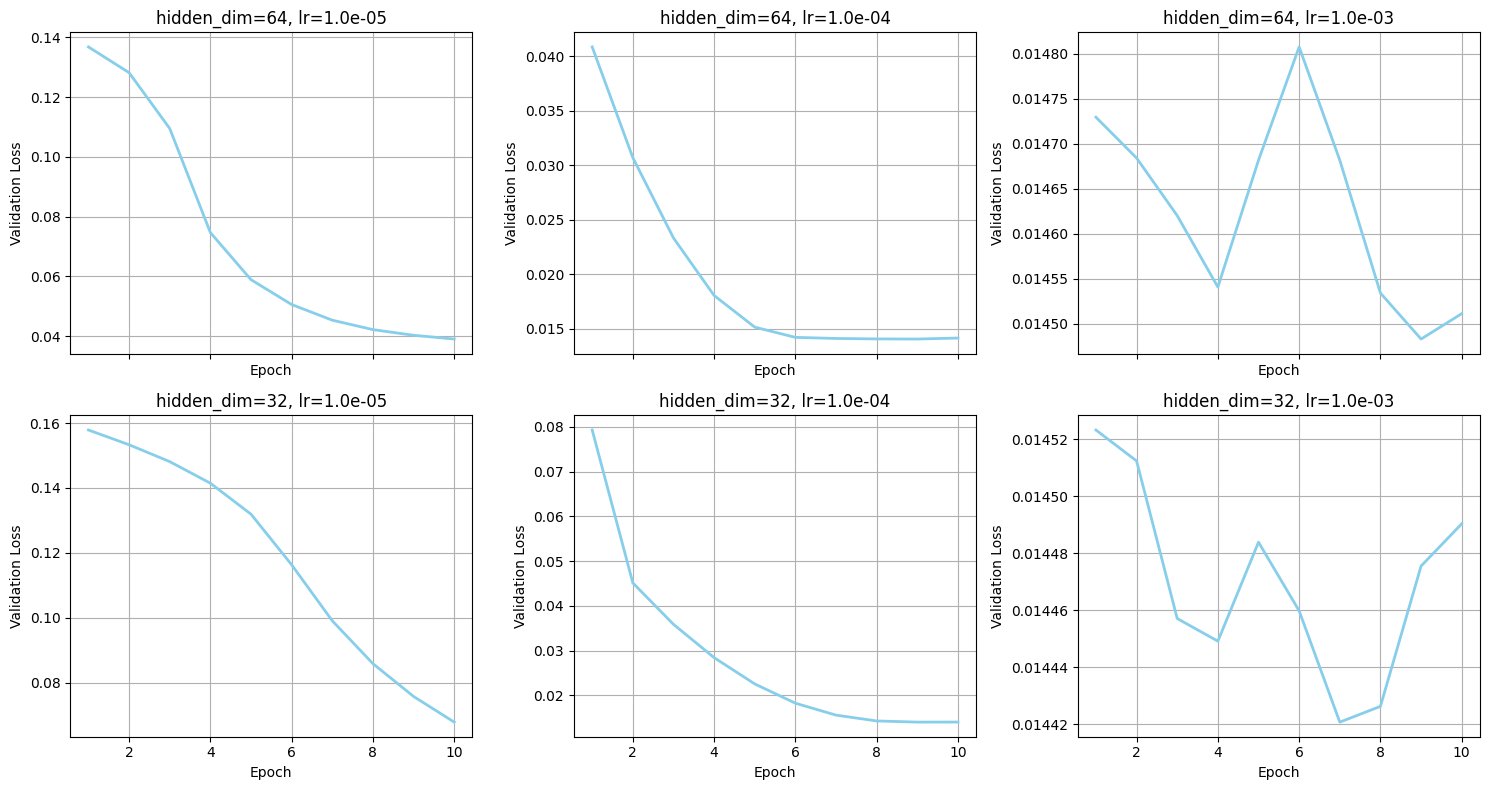

In [61]:
trial_dir = "/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder/pre_train_autoencoder"
plot_loss(trial_dir)

In [ ]:

best_pre_train_model = "/home/mei/nas/docker/thesis/data/model/pre_train_autoencoder/best_model.pth"

the model is stored at: /home/mei/nas/docker/thesis/data/model/pre_train_autoencoder/best_model.pth


## fine tune for searching lr under the hidden_dim = 32

In [6]:
def train_autoencoder_32(config, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = TimeSeriesAutoencoder(
        input_dim=config["input_dim"],
        hidden_dim=config["hidden_dim"],
    ).to(device)
    
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    best_val_loss = float("inf")
    model_dir= "/home/mei/nas/docker/thesis/data/model/pre_train_autoencoder"  
    os.makedirs(model_dir, exist_ok=True)
    best_model_path = os.path.join(model_dir, "best_model_32.pth")
    
    for epoch in range(config["epochs"]):
        model.train()
        for batch in train_loader:
            inputs, lengths = batch
            inputs = inputs.to(device)
            lengths = lengths.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs, lengths)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs, lengths = batch
                inputs = inputs.to(device)
                lengths = lengths.to(device)
                outputs, _ = model(inputs, lengths)
                loss = criterion(outputs, inputs)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{config['epochs']}, Validation Loss: {val_loss:.4f}")
        tune.report({"val_loss": val_loss})
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
    
    print(f"Best validation loss: {best_val_loss}")

In [4]:
def tune_autoencoder_lr(train_loader, val_loader):
    search_space = {
        "input_dim": 324, 
        "hidden_dim":32,
        "lr": tune.loguniform(1e-4, 1e-3),
        "epochs": 10,
    }
    
    algo = BasicVariantGenerator()
    scheduler = ASHAScheduler(
        max_t=10,  
        grace_period=5,  
        reduction_factor=2, 
    )
    tuner = tune.Tuner(
        tune.with_resources(
        tune.with_parameters(train_autoencoder_32, train_loader=train_loader, val_loader=val_loader),
        resources={"cpu": 4, "gpu": 2}  
    ),
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            search_alg=algo,
            scheduler=scheduler,
            num_samples = 4,
        ),
        run_config=tune.RunConfig(
            stop={"training_iteration": 10},  # 
            name="pre_train_autoencoder_32", 
            storage_path="/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder",
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    best_config = results.get_best_result().config

    print("Best Hyperparameters under the hidden layer 32:", best_config)
    return best_config

In [8]:
import ray
ray.init()
print(ray.available_resources()) 

2025-03-07 21:32:48,653	INFO worker.py:1841 -- Started a local Ray instance.


{'node:__internal_head__': 1.0, 'CPU': 64.0, 'object_store_memory': 200000000000.0, 'node:192.168.60.144': 1.0, 'accelerator_type:RTX': 1.0, 'GPU': 8.0, 'memory': 854265990144.0}


In [9]:
import ray
ray.shutdown()
ray.init(runtime_env={"working_dir": "/home/mei/nas/docker/thesis/model_train"})
ray.init(ignore_reinit_error=True, _temp_dir="/home/mei/nas/docker/thesis/data/ray_results")

2025-03-07 21:33:24,509	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-07 21:33:24,566	INFO packaging.py:575 -- Creating a file package for local module '/home/mei/nas/docker/thesis/model_train'.
2025-03-07 21:33:24,628	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_563966cb8df7a337.zip' (1.88MiB) to Ray cluster...
2025-03-07 21:33:24,637	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_563966cb8df7a337.zip'.
2025-03-07 21:33:25,412	INFO worker.py:1672 -- Calling ray.init() again after it has already been called.


Python version:,3.10.14
Ray version:,2.43.0


(train_autoencoder_32 pid=1692450) Epoch 1/10, Validation Loss: 0.0147
(train_autoencoder_32 pid=1692452) Epoch 1/10, Validation Loss: 0.0217
(train_autoencoder_32 pid=1692449) Epoch 1/10, Validation Loss: 0.0328
(train_autoencoder_32 pid=1692451) Epoch 1/10, Validation Loss: 0.0171
(train_autoencoder_32 pid=1692450) Epoch 2/10, Validation Loss: 0.0145
(train_autoencoder_32 pid=1692452) Epoch 2/10, Validation Loss: 0.0144
(train_autoencoder_32 pid=1692449) Epoch 2/10, Validation Loss: 0.0173
(train_autoencoder_32 pid=1692451) Epoch 2/10, Validation Loss: 0.0144
(train_autoencoder_32 pid=1692450) Epoch 3/10, Validation Loss: 0.0148
(train_autoencoder_32 pid=1692452) Epoch 3/10, Validation Loss: 0.0143
(train_autoencoder_32 pid=1692449) Epoch 3/10, Validation Loss: 0.0142
(train_autoencoder_32 pid=1692451) Epoch 3/10, Validation Loss: 0.0144
(train_autoencoder_32 pid=1692452) Epoch 4/10, Validation Loss: 0.0143
(train_autoencoder_32 pid=1692449) Epoch 4/10, Validation Loss: 0.0141 [repea

In [10]:
best_params_32 = tune_autoencoder_lr(lstm_loader_train,lstm_loader_val)

2025-03-08 07:30:27,912	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder/pre_train_autoencoder_32' in 0.0354s.
2025-03-08 07:30:27,921	INFO tune.py:1041 -- Total run time: 35809.57 seconds (35809.49 seconds for the tuning loop).


Best Hyperparameters under the hidden layer 32: {'input_dim': 324, 'hidden_dim': 32, 'lr': 0.00031631947004257855, 'epochs': 10}


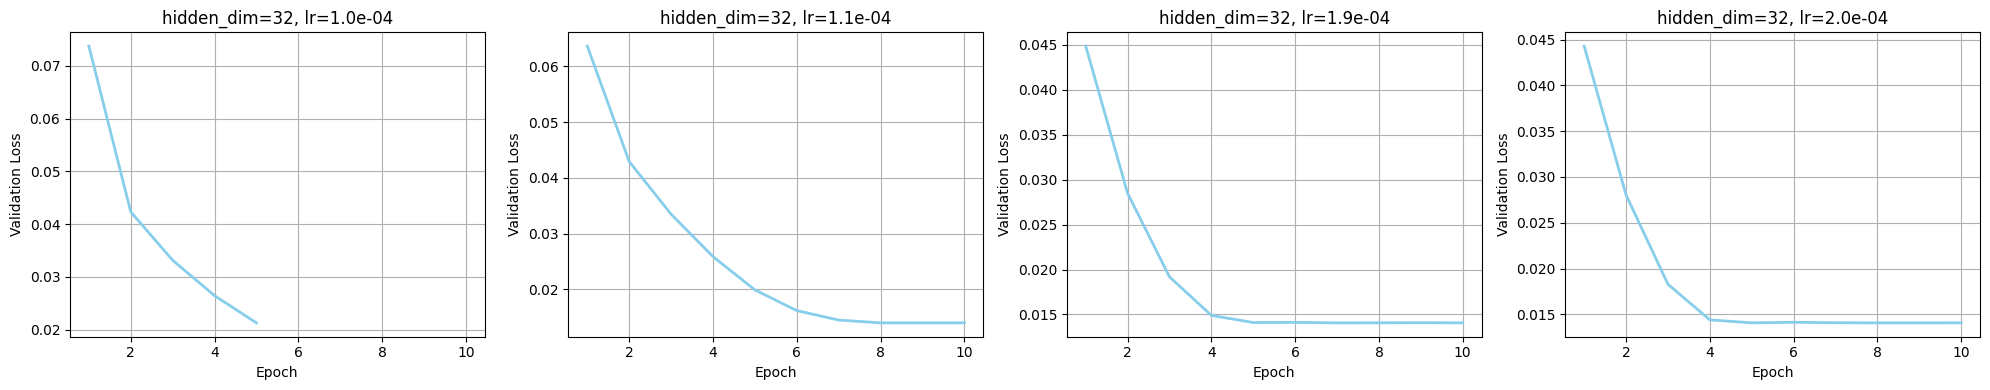

In [5]:
trial_dir = "/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder/pre_train_autoencoder_32"
plot_loss(trial_dir)

## try again

In [9]:
def train_autoencoder_32_v2(config, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = TimeSeriesAutoencoder(
        input_dim=config["input_dim"],
        hidden_dim=config["hidden_dim"],
    ).to(device)
    
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    best_val_loss = float("inf")
    model_dir= "/home/mei/nas/docker/thesis/data/model/pre_train_autoencoder"  
    os.makedirs(model_dir, exist_ok=True)
    best_model_path = os.path.join(model_dir, "best_model_32_v2.pth")
    
    for epoch in range(config["epochs"]):
        model.train()
        for batch in train_loader:
            inputs, lengths = batch
            inputs = inputs.to(device)
            lengths = lengths.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs, lengths)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs, lengths = batch
                inputs = inputs.to(device)
                lengths = lengths.to(device)
                outputs, _ = model(inputs, lengths)
                loss = criterion(outputs, inputs)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{config['epochs']}, Validation Loss: {val_loss:.4f}")
        tune.report({"val_loss": val_loss})
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
    
    print(f"Best validation loss: {best_val_loss}")

In [10]:
def tune_autoencoder_lr_v2(train_loader, val_loader):
    search_space = {
        "input_dim": 324, 
        "hidden_dim":32,
        "lr": tune.loguniform(1e-4, 2e-4),
        "epochs": 10,
    }
    
    algo = BasicVariantGenerator()
    scheduler = ASHAScheduler(
        max_t=10,  
        grace_period=5,  
        reduction_factor=2, 
    )
    tuner = tune.Tuner(
        tune.with_resources(
        tune.with_parameters(train_autoencoder_32_v2, train_loader=train_loader, val_loader=val_loader),
        resources={"cpu": 4, "gpu": 2}  
    ),
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            search_alg=algo,
            scheduler=scheduler,
            num_samples = 4,
        ),
        run_config=tune.RunConfig(
            stop={"training_iteration": 10},  # 
            name="pre_train_autoencoder_32_v2", 
            storage_path="/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder",
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    best_config = results.get_best_result().config

    print("Best Hyperparameters under the hidden layer 32:", best_config)
    return best_config

In [11]:
import ray
ray.init()
print(ray.available_resources()) 

2025-03-08 22:54:26,057	INFO worker.py:1841 -- Started a local Ray instance.


{'node:__internal_head__': 1.0, 'CPU': 64.0, 'object_store_memory': 200000000000.0, 'accelerator_type:RTX': 1.0, 'node:192.168.60.144': 1.0, 'GPU': 8.0, 'memory': 857006496768.0}


In [12]:
import ray
ray.shutdown()
ray.init(runtime_env={"working_dir": "/home/mei/nas/docker/thesis/model_train"})
ray.init(ignore_reinit_error=True, _temp_dir="/home/mei/nas/docker/thesis/data/ray_results")

2025-03-08 22:54:33,925	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-08 22:54:33,984	INFO packaging.py:575 -- Creating a file package for local module '/home/mei/nas/docker/thesis/model_train'.
2025-03-08 22:54:34,048	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_6e5b0d79d0193f49.zip' (1.89MiB) to Ray cluster...
2025-03-08 22:54:34,057	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_6e5b0d79d0193f49.zip'.
2025-03-08 22:54:34,843	INFO worker.py:1672 -- Calling ray.init() again after it has already been called.


Python version:,3.10.14
Ray version:,2.43.0


(train_autoencoder_32_v2 pid=2671107) Epoch 1/10, Validation Loss: 0.0513
(train_autoencoder_32_v2 pid=2671104) Epoch 1/10, Validation Loss: 0.0674
(train_autoencoder_32_v2 pid=2671106) Epoch 1/10, Validation Loss: 0.0515
(train_autoencoder_32_v2 pid=2671107) Epoch 2/10, Validation Loss: 0.0337 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_autoencoder_32_v2 pid=2671104) Epoch 2/10, Validation Loss: 0.0405
(train_autoencoder_32_v2 pid=2671106) Epoch 2/10, Validation Loss: 0.0358
(train_autoencoder_32_v2 pid=2671105) Epoch 2/10, Validation Loss: 0.0305
(train_autoencoder_32_v2 pid=2671107) Epoch 3/10, Validation Loss: 0.0234
(train_autoencoder_32_v2 pid=2671104) Epoch 3/10, Validation Loss: 0.0313
(train_autoencoder_32_v2 pid=2671106) Epoch 3/10, Validation Loss: 0.0259
(train_autoencoder

In [13]:
best_params_32_v2 = tune_autoencoder_lr_v2(lstm_loader_train,lstm_loader_val)

2025-03-09 08:53:27,368	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder/pre_train_autoencoder_32_v2' in 0.0310s.
2025-03-09 08:53:27,377	INFO tune.py:1041 -- Total run time: 35891.67 seconds (35891.60 seconds for the tuning loop).


Best Hyperparameters under the hidden layer 32: {'input_dim': 324, 'hidden_dim': 32, 'lr': 0.0001738161535741444, 'epochs': 10}


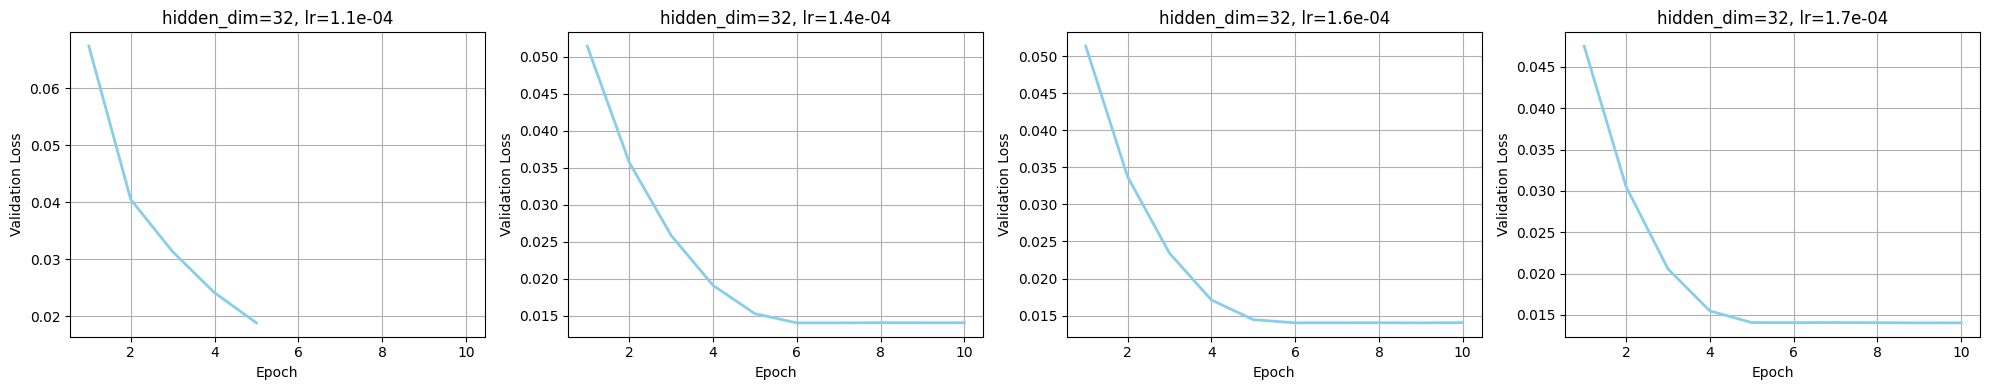

In [63]:
results_dir = "/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder/pre_train_autoencoder_32_v2"
plot_loss(results_dir)